In [ ]:
# !pip install imblearn

In [91]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.impute import MissingIndicator, SimpleImputer

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel

# plot_confusion_matrix is a handy visual tool, added in the latest version of scikit-learn
# if you are running an older version, comment out this line and just use confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [100]:
# function for specifically encoding artist names using OneHotEncoder

def encode_artist_name(x):
    '''
    This is a helper function for load_and_format_x_y()
    This function takes in a dataframe of x predictors. 
    Initiates a OneHotEncoder with handle_unknown="ignore" to 
    compensate for unseen artists in new data, 
    And returns the dataframe with the artist column encoded.
    '''
    # initiate OHE
    ohe = OneHotEncoder(categories="auto", handle_unknown="ignore")
    # dataframe of just encoded columns, using x_train index as it's index to ensure rows line up
    ohe.fit(x[['artist_name']])
    artist_dummies = pd.DataFrame(ohe.transform(x[['artist_name']]).todense(), columns=ohe.get_feature_names(), index=x.index)
    # concat encoded columns to x
    concatted_x = pd.concat([x, artist_dummies], axis=1)
    #add column names
    concatted_x.columns = list(x.columns) + list(artist_dummies)
    concatted_x = concatted_x.drop('artist_name', axis=1)
    return concatted_x

In [101]:
def load_and_format_x_y():
    '''
    This is a helper function for format_data_for_model()
    This function takes in a raw data frame, 
    Formats data, 
    And returns X and y pandas dataframes
    '''
    # load data into dataframe
    df = pd.read_csv('../../Data/music_subset.csv')
    # drop extra axis column from csv file
    df = df.drop('Unnamed: 0', axis=1).set_index('track_id')
    # remove songs in 'classic pop and rock' genre
    df = df[df['genre'] != 'classic pop and rock']
    # split data into X and y dataframes
    X = df.drop('genre', axis=1)
    y = df['genre']
    # encode artist column in X
    X = encode_artist_name(X)
    
    return X, y

In [103]:
def format_data_for_model():
    '''
    This function takes in a dataframe, 
    Removes unwanted columns and the 'classic pop and rock', 
    Genre because of it's size and ambiguity, 
    Performs a train test split, 
    Initates a SMOTE object and uses it to generate data points in the 
    test data in order to balance class sizes, 
    And returns resampled train X and y sets and test X and y sets 
    formatted to train model
    '''
    #format raw dataframe
    X, y = load_and_format_x_y()
    
    # train test split data with stratify to create class 
    # equality between train and test data
    x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y)
    # drop title column (string, useless category)
    x_test = x_test.drop('title', axis=1)
    x_train = x_train.drop('title', axis=1)
    
    
    return x_train, y_train, x_test, y_test

In [99]:
x_train, y_train, x_test, y_test = format_data_for_model()

In [ ]:
rf = fit_model(x_train, y_train)

In [83]:
model_predict_and_report(rf, x_test, y_test)

                       precision    recall  f1-score   support

            classical       0.83      0.93      0.88       469
dance and electronica       0.89      0.86      0.88      1234
                 folk       0.90      0.93      0.91      3298
              hip-hop       0.88      0.85      0.87       108
       jazz and blues       0.90      0.81      0.86      1084
                metal       0.92      0.94      0.93       526
                  pop       0.95      0.89      0.92       404
                 punk       0.89      0.86      0.87       800
      soul and reggae       0.89      0.90      0.90      1004

             accuracy                           0.90      8927
            macro avg       0.90      0.89      0.89      8927
         weighted avg       0.90      0.90      0.89      8927



array(['folk', 'folk', 'folk', ..., 'folk', 'folk', 'punk'], dtype=object)

## hyperparameter tuning

In [105]:
rf = RandomForestClassifier(n_jobs=-1, max_features=15)
rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=15,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [115]:
sorted(list(zip(rf.feature_importances_, x_train.columns)), key= lambda x: x[0])[-15:]

[(0.021078575547197904, 'avg_timbre10'),
 (0.021645061353727686, 'var_timbre3'),
 (0.02196735074538892, 'var_timbre4'),
 (0.022201689196601142, 'var_timbre2'),
 (0.02267007797133865, 'var_timbre6'),
 (0.022692253437208813, 'avg_timbre3'),
 (0.023362828185577, 'var_timbre8'),
 (0.023672076205736945, 'var_timbre11'),
 (0.02435757908419509, 'avg_timbre5'),
 (0.024623622861060346, 'avg_timbre6'),
 (0.025549909270907487, 'var_timbre10'),
 (0.026829735272470064, 'duration'),
 (0.028107776237420144, 'avg_timbre2'),
 (0.03010197469149136, 'avg_timbre1'),
 (0.03175655536544847, 'loudness')]

In [57]:
print(classification_report(y_train, rf.predict(x_train), output_dict=True)['accuracy'])

1.0


In [71]:
feat_nums = [10, 8, 6, 5]
models = []
for k in range(len(feat_nums)):
    rf = RandomForestClassifier(n_jobs=-1, max_features=feat_nums[k])
    rf.fit(x_train, y_train)
    models.append(rf)
    print(f'model for {feat_nums[k]} features trained')

model for 10 features trained
model for 8 features trained
model for 6 features trained
model for 5 features trained


In [72]:
accuracies = []
for k in range(len(feat_nums)):
    accuracy = classification_report(y_test, models[k].predict(x_test), output_dict=True)['accuracy']
    accuracies.append(accuracy)

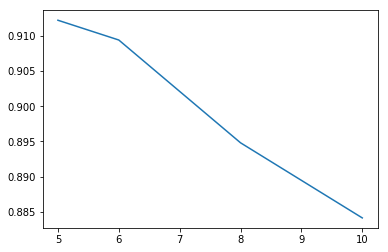

In [73]:
fig, ax = plt.subplots()
ax = plt.plot(feat_nums, accuracies)


In [50]:
print(classification_report(y_test, rf.predict(x_test)))

                       precision    recall  f1-score   support

            classical       0.77      0.91      0.83       469
dance and electronica       0.81      0.78      0.79      1234
                 folk       0.86      0.89      0.87      3298
              hip-hop       0.91      0.80      0.85       108
       jazz and blues       0.83      0.75      0.79      1084
                metal       0.90      0.92      0.91       526
                  pop       0.92      0.85      0.88       404
                 punk       0.88      0.82      0.85       800
      soul and reggae       0.82      0.84      0.83      1004

             accuracy                           0.84      8927
            macro avg       0.85      0.84      0.84      8927
         weighted avg       0.85      0.84      0.84      8927



#### gridsearchCV for hyperparameter tuning (TAKES FOREVER, have yet to run all the way thorugh)

In [49]:
# criterion, min_samples_split, min_samples_leaf, max_features --->
param_grid = {'criterion': ['gini', 'entropy'], 
              'min_samples_leaf': [1,2,3],
              'max_features': ['log2', 10, 15, 20]}

In [56]:
rf = RandomForestClassifier(n_estimators=20, class_weight='balanced', n_jobs=-1)
random_gs = GridSearchCV(rf, param_grid)

In [57]:
rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [58]:
random_gs.fit(x_train, y_train)

KeyboardInterrupt: 

In [26]:
2+2

4

## feature exploration

In [ ]:
fig, ax = plt.subplots()
ax = sns.stripplot(x='genre', y="duration", data=df)
ax.set_xticklabels(labels=df['genre'].value_counts().index, rotation=45)